In [ ]:
#default_exp data.annotation

In [ ]:
#export
from collections import UserList
from copy import deepcopy
from dataclasses import replace
from mantisshrimp.imports import *
from mantisshrimp.core import *
from mantisshrimp.data.core import *

# Data annotation
> Functions for getting annotatations in a standard format

## Custom types

In [ ]:
#export
@dataclass
class Mask:
    data: np.ndarray
    def __post_init__(self): self.data = self.data.astype(np.uint8)
    def __len__(self): return len(self.data)
    def __getitem__(self, i): return type(self)(self.data[i])
    
    def to_tensor(self): return tensor(self.data, dtype=torch.uint8)
    def to_mask(self, h, w): return self
    def to_erle(self, h, w): 
        return mask_utils.encode(np.asfortranarray(self.data.transpose(1,2,0)))
    
    @property
    def shape(self): return self.data.shape
    
    @classmethod
    def from_segs(cls, segs, h, w):
        masks = []
        # TODO: Instead of if checks, RLE and Polygon can return with extra dim
        for o in segs:
            m = o.to_mask(h,w).data
            if isinstance(o, (RLE, Polygon)): masks.append(m[None])
            elif isinstance(o, MaskFile): masks.append(m)
            else: raise ValueError(f'Segmented type {type(o)} not supported')
        return cls(np.concatenate(masks))

In [ ]:
#export
@dataclass(frozen=True)
class MaskFile:
    fp: Union[str, Path]
    def __post_init__(self): self.fp = Path(self.fp)
    def to_mask(self, h, w):
        mask = open_img(self.fp, gray=True)
        obj_ids = np.unique(mask)[1:]
        masks = mask==obj_ids[:, None, None]
        return Mask(masks)
    def to_erle(self, h, w): return self.to_mask(h,w).to_erle(h,w)

In [ ]:
#export
@dataclass(frozen=True)
class RLE:
    counts: List[int]
    def to_mask(self, h, w):
        'From https://www.kaggle.com/julienbeaulieu/imaterialist-detectron2'
        mask = np.full(h*w, 0, dtype=np.uint8)
        for i, start_pixel in enumerate(self.counts[::2]):
            mask[start_pixel:start_pixel+self.counts[2*i+1]] = 1
        mask = mask.reshape((h, w), order='F')
        return Mask(mask)
#     def to_mask(self, h, w):
#         erle = self.to_erle(h=h, w=w)
#         mask = mask_utils.decode(erle).sum(axis=-1)
#         assert mask.max() == 1, 'Probable inconsistency in counts'
#         return Mask(mask)
    def to_erle(self, h, w):
        raise NotImplementedError('Convert counts to coco style')
        return mask_utils.frPyObjects([{'counts':self.counts, 'size':[h,w]}], h, w)
    @classmethod
    def from_string(cls, s, sep=' '):
        return cls(lmap(int, s.split(sep)))
#     @classmethod
#     def from_kaggle(cls, counts):
#         'Described [here](https://www.kaggle.com/c/imaterialist-fashion-2020-fgvc7/overview/evaluation)'
#         if len(counts)%2 != 0: raise ValueError('Counts must be divisible by 2')
#         total = 0
#         coco_counts = []
#         for i,n in zip(counts[::2], counts[1::2]):
#             coco_counts.append(i-1-total) # 0s
#             coco_counts.append(n) # 1s
#             total = i+n-1
#         return cls(coco_counts)
    @classmethod
    def from_kaggle(cls, counts):
        'Described [here](https://www.kaggle.com/c/imaterialist-fashion-2020-fgvc7/overview/evaluation)'
        if len(counts)%2 != 0: raise ValueError('Counts must be divisible by 2')
        return cls(counts)
    @classmethod
    def from_coco(cls, counts):
        'Described [here](https://stackoverflow.com/a/49547872/6772672)'
        kaggle_counts,total = [],0
        for zrs,ons in zip(counts[::2], counts[1::2]):
            kaggle_counts.extend([zrs+total+1, ons])
            total += zrs+ons
        return cls.from_kaggle(kaggle_counts)

In [ ]:
rle = RLE.from_coco([0,3,3,2,6,1])
test_eq(rle.counts, [1,3,7,2,15,1])
# rle = RLE.from_kaggle([1,3,7,2,15,1])
# test_eq(rle.counts, [0,3,3,2,6,1])

In [ ]:
#export
@dataclass(frozen=True)
class Polygon:
    pnts: List[List[int]]
    def to_mask(self, h, w): 
        erle = self.to_erle(h=h, w=w)
        mask = mask_utils.decode(erle).sum(axis=-1) # Sum is for unconnected polygons
        assert mask.max() == 1, 'Probable overlap in polygons'
        return Mask(mask)
    def to_erle(self, h, w): return mask_utils.frPyObjects(self.pnts, h, w)

In [ ]:
#export
@dataclass
class BBox:
    pnts: List[int]
    def __post_init__(self):
        if self.pnts:
            xl,yu,xr,yb = self.pnts
            self.x,self.y,self.h,self.w = xl,yu,(yb-yu),(xr-xl)
            self.area = self.h*self.w
            
    @property
    def xyxy(self): return self.pnts
    @property
    def xywh(self): return [self.x,self.y,self.w,self.h]
    @classmethod
    def from_xywh(cls, x, y, w, h): return cls([x,y,x+w,y+h])
    @classmethod
    def from_xyxy(cls, xl, yu, xr, yb): return cls([xl,yu,xr,yb])
    
    def to_tensor(self): return tensor(self.xyxy, dtype=torch.float)
    
    @classmethod
    def from_rle(cls, rle, h, w):
        a = np.array(rle.counts, dtype=np.uint)
        a = a.reshape((-1, 2))  # an array of (start, length) pairs
        a[:,0] -= 1  # `start` is 1-indexed
        y0 = a[:,0] % h
        y1 = y0 + a[:,1]
        if np.any(y1 > h):
            # got `y` overrun, meaning that there are a pixels in mask on 0 and shape[0] position
            y0 = 0
            y1 = h
        else:
            y0 = np.min(y0)
            y1 = np.max(y1)
        x0 = a[:,0] // h
        x1 = (a[:,0] + a[:,1]) // h
        x0 = np.min(x0)
        x1 = np.max(x1)
        if x1 > w:
            # just went out of the image dimensions
            raise ValueError(f"invalid RLE or image dimensions: x1={x1} > shape[1]={w}")
        return cls.from_xyxy(x0, y0, x1, y1)

## Annotations

In [ ]:
#export
@dataclass
class ImageInfo:
    # TODO: Can add width and height
    iid: int
    fp: Union[str, Path]
    split: int
    h: int
    w: int
        
    def __post_init__(self): self.fp = Path(self.fp)

In [ ]:
#export
@dataclass
class Instance:
    oid: int
    bbox: BBox=None
    seg: Polygon=None
    kpts: List=None # TODO
    iscrowd: int=None

In [ ]:
#export
# TODO: Better way to handle empty oids, bboxes, kpts, segs etcs
@dataclass
class Annotation:
    iid: int
    oids: List[int]
    bboxes: List[BBox]=None
    segs: List[Polygon]=None
    kpts: List[int]=None # TODO
    iscrowds: List[int]=None
        
#     def __post_init__(self):
#         insts = [self.oids,self.bboxes,self.segs,self.kpts,self.iscrowds]
#         lens = [len(o) for o in insts if notnone(o)]
#         if not allequal(lens): raise ValueError(f'All annotations should have the same size: {lens}')
#         assert len(self.bboxes)==len(self.segs)
    def __getitem__(self, i):
        # TODO: Needs to be refactored?
        bbox = self.bboxes[i] if notnone(self.bboxes) else None
        seg = self.segs[i] if (notnone(self.segs) and len(self.segs)>i) else None # Single mask file can contain multiple masks
        kpts = self.kpts[i] if notnone(self.kpts) else None
        iscrowd = self.iscrowds[i] if notnone(self.iscrowds) else None
        return Instance(oid=self.oids[i],bbox=bbox,seg=seg,kpts=None,iscrowd=iscrowd) #kpts None
    
    def get_mask(self, h, w): 
#         return [Mask.from_segs([o],h,w) for o in self.segs]
        return Mask.from_segs(self.segs,h,w) if notnone(self.segs) else None

In [ ]:
#export
@dataclass
class Record:
    iinfo: ImageInfo
    annot: Annotation
        
    def new(self, *, iinfo=None, annot=None):
        iinfo = replace(self.iinfo, **(iinfo or {}))
        annot = replace(self.annot, **(annot or {}))
        return replace(self, iinfo=iinfo, annot=annot)
    
    def to_rcnn_target(self):
        r = {
            'image_id': tensor(self.iinfo.iid, dtype=torch.int64),
            'labels': tensor(self.annot.oids),
            'boxes': torch.stack([o.to_tensor() for o in self.annot.bboxes]),
        #     'keypoints': self.annot.kpts.to_tensor(), # TODO
            'area': tensor([o.area for o in self.annot.bboxes]),
            'iscrowd': tensor(self.annot.iscrowds, dtype=torch.uint8),
        }
        segs = self.annot.segs
        if notnone(segs):
            if isinstance(segs, Mask): m = segs
            elif isinstance(segs, list): m = Mask.from_segs(segs, self.iinfo.h, self.iinfo.w)
            else: raise ValueError(f'Type for masks {type(masks)} not supported')
            r['masks'] = m.to_tensor()
        # TODO: Check all shapes have N
        return r

## Parsers

In [ ]:
#export
class DataSplit:
    Train = 0
    Valid = 1
    Test = 2

In [ ]:
#export
def random_split(p=None, splits=None):
    p = p or [.8, .2]
    splits = splits or [DataSplit.Train, DataSplit.Valid, DataSplit.Test][:len(p)]
    return np.random.choice(splits, p=p)

In [ ]:
#export
class ImageParser:
    def __init__(self, data, source): self.data,self.source = data,Path(source)
    def __iter__(self): yield from self.data
    def __len__(self): return len(self.data)
        
    def prepare(self, o): pass
    def iid(self, o): raise NotImplementedError
    def file_path(self, o): raise NotImplementedError
    def height(self, o): raise NotImplementedError
    def width(self, o): raise NotImplementedError
    def split(self, o): return random_split()
        
    def parse(self):
        xs,iids = [],[]
        for o in tqdm(self):
            self.prepare(o)
            iid = self.iid(o)
            if iid not in iids:
                iids.append(iid)
                xs.append(ImageInfo(iid=self.iid(o), fp=self.file_path(o), split=self.split(o),
                                    h=self.height(o), w=self.width(o)))
        return xs

In [ ]:
#export
class AnnotationParser:
    def __init__(self, data, source, catmap): self.data,self.source,self.catmap = data,source,catmap
    def __iter__(self): yield from self.data
    def __len__(self): return len(self.data)
    # Methods to override
    def prepare(self, o): pass
    def bbox(self, o): pass
    def iid(self, o): pass
    def seg(self, o): pass
    def iscrowd(self, o): return 0
    
    # TODO: Refactor
    def parse(self):
        res = defaultdict(dict)
        iids = set()
        bboxes = defaultdict(list)
        segs = defaultdict(list)
        oids = defaultdict(list)
        iscrowds = defaultdict(list)
        for o in tqdm(self):
            self.prepare(o)
            # TODO: Refactor with python 3.8 walrus syntax
            iid = self.iid(o)
            bbox = self.bbox(o)
            seg = self.seg(o)
            oid = self.oid(o)
            iscrowd = self.iscrowd(o)
            if oid is not None: oids[iid].extend(L(oid))
            if bbox is not None: bboxes[iid].extend(L(bbox))
            if seg is not None: segs[iid].extend(L(seg))
            if iscrowd is not None: iscrowds[iid].extend(L(iscrowd))
            iids.add(iid)
        for d in [bboxes,segs,oids,iscrowds]: d.default_factory = lambda: None
        return [Annotation(i, oids[i], bboxes=bboxes[i], segs=segs[i], iscrowds=iscrowds[i]) for i in iids]

In [ ]:
#export
@funcs_kwargs
class DataParser:
    _methods = 'img_parser annot_parser'.split()
    def __init__(self, data, source, catmap, **kwargs): self.data,self.source,self.catmap=data,source,catmap
    def img_parser(self, o, source): raise NotImplementedError
    def annot_parser(self, o, source): raise NotImplementedError
        
    def parse(self):
        imgs = L(self.img_parser(self.data, self.source).parse())
        annots = L(self.annot_parser(self.data, self.source, self.catmap).parse())
        # Remove imgs that don't have annotations
        img_iids = set(imgs.attrgot('iid'))
        valid_iids = set(annots.attrgot('iid'))
        if not valid_iids.issubset(img_iids):
            raise ValueError(f'iids {valid_iids-img_iids} present in annotations but not in images')
        valid_imgs = imgs.filter(lambda o: o.iid in valid_iids)
        print(f"Removed {len(imgs)-len(valid_iids)} images that don't have annotations")
        # Sort and get items
        assert len(annots)==len(valid_imgs)
        valid_imgs.sort(attrgetter('iid'))
        annots.sort(attrgetter('iid'))
        records = defaultdict(list)
        for iinfo,annot in zip(valid_imgs,annots):
            records[iinfo.split].append(Record(iinfo,annot))
        return [records[k] for k in records.keys()]

## COCO Parsers

In [ ]:
#export
class COCOImageParser(ImageParser):
    def iid(self, o): return o['id']
    def file_path(self, o): return self.source/o['file_name']
    def height(self, o): return o['height']
    def width(self, o): return o['width']

In [ ]:
#export
class COCOAnnotationParser(AnnotationParser):
    def iid(self, o):  return o['image_id']
    def oid(self, o): return o['category_id']
    def bbox(self, o): return BBox.from_xywh(*o['bbox'])
    def iscrowd(self, o): return o['iscrowd']
    def seg(self, o):
        seg = o['segmentation']
        if o['iscrowd']: return RLE.from_coco(seg['counts'])
        else: return Polygon(seg)

In [ ]:
#export
class COCOParser(DataParser):
    def img_parser(self, o, source): return COCOImageParser(o['images'], source)
    def annot_parser(self, o, source, catmat): return COCOAnnotationParser(o['annotations'], source, catmap)

In [ ]:
source = Path('samples')
annot_json = json.load((source/'annotations.json').open())

In [ ]:
cats = [Category(o['id'], o['name']) for o in annot_json['categories']]
catmap = CategoryMap(cats)

In [ ]:
parser = COCOParser(annot_json, 'samples/images', catmap)

In [ ]:
# TODO: Random splitter sometimes rvalid is empty
with np_local_seed(42): rtrain,rvalid = parser.parse()


Removed 0 images that don't have annotations


In [ ]:
test_eq(len(rtrain)+len(rvalid), 5)

In [ ]:
# TODO: Splits are random, tests fail
r = rtrain[0]
test_eq((r.iinfo.h, r.iinfo.w), (427, 640))
test_eq(r.iinfo.iid, 128372)
test_eq(r.annot[0].bbox.xywh, [0.0, 73.89, 416.44, 305.13])

In [ ]:
r.annot.segs[0].to_mask(r.iinfo.h, r.iinfo.w).data.shape

(427, 640)

In [ ]:
new = r.new(annot=dict(bboxes=[BBox.from_xyxy(1,2,3,4) for _ in r.annot.bboxes]))

In [ ]:
test_ne(new.annot.bboxes, r.annot.bboxes)

In [ ]:
r.to_rcnn_target()['masks'].shape

torch.Size([16, 427, 640])

## Visualize

In [ ]:
#export
from matplotlib import patches
from matplotlib.collections import PatchCollection

In [ ]:
#export
def draw_label(ax, x, y, name, color, fontsize=18):
    ax.text(x+1, y-2, name, fontsize=fontsize, color='white', va='bottom',
            bbox=dict(facecolor=color, edgecolor=color, pad=2, alpha=.9))

In [ ]:
#export
def bbox_polygon(bbox):
    bx, by, bw, bh = bbox.xywh
    poly = np.array([[bx,by], [bx,by+bh], [bx+bw,by+bh], [bx+bw,by]])
    return patches.Polygon(poly)

In [ ]:
#export
def draw_mask(ax, mask, color):
    color_mask = np.ones((*mask.shape,3)) * color
    ax.imshow(np.dstack((color_mask,mask*.5)))
    ax.contour(mask, colors=[color_mask[0,0,:]], alpha=.4)

In [ ]:
#export
def show_annot(im, labels=None, bboxes=None, masks=None, ax=None, figsize=None):
    # Sample colors at the end
    ax = show_img(im, ax=ax, figsize=figsize or (10,10))
    polygons,colors = [],[]
    for label,bbox,mask in itertools.zip_longest(*[ifnone(o,[]) for o in [labels,bboxes,masks]]):
        color = (np.random.random(3)*0.6+0.4)
        colors.append(color)
        if notnone(bbox): polygons.append(bbox_polygon(bbox))
        if notnone(mask): draw_mask(ax, mask.data.copy(), color)
        if notnone(label):
            if notnone(bbox): x,y = bbox.x,bbox.y
            elif notnone(mask): y,x = np.unravel_index(mask.data.argmax(), mask.data.shape)
            else: raise ValueError('Can only display labels if bboxes or masks are given')
            draw_label(ax, x=x, y=y, name=label, color=color)

    p = PatchCollection(polygons, facecolor=colors, linewidths=0, alpha=0.3)
    ax.add_collection(p)
    p = PatchCollection(polygons, facecolor='none', edgecolors=colors, linewidths=2)
    ax.add_collection(p)

In [ ]:
#export
def show_record(r, label=True, bbox=True, mask=True, ax=None):
    im = open_img(r.iinfo.fp)
    h,w,_ = im.shape
    return show_annot(im, ax=ax,
                      labels=r.annot.oids if label else None,
                      bboxes=r.annot.bboxes if bbox else None,
                      masks=r.annot.get_mask(h,w) if mask else None)

In [ ]:
# TODO: Deprecated
# def show_record(record, im=None, id2cat=None, bbox=True, labels=True, fontsize=18, ax=None, **kwargs):
#     'From github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py#L233'
#     im = im if notnone(im) else open_img(record.iinfo.fp)
#     height,width,_ = im.shape
#     ax = show_img(im, ax=ax, **kwargs)
#     ax.set_autoscale_on(False)
#     polygons = []
#     color = []
#     for ann in record.annot:
#         c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
#         # Assert both seg and masks are not present, or unify view
#         if ann.seg is not None:
#             if isinstance(ann.seg, Polygon):
#                 for seg in ann.seg.pnts:
#                     poly = np.array(seg).reshape((int(len(seg)/2), 2))
#                     polygons.append(patches.Polygon(poly))
#                     color.append(c)
#             elif isinstance(ann.seg, RLE):
#                 if isinstance(ann.seg.counts, list):
# #                     rle = mask_utils.frPyObjects([ann.seg.counts], height, width)
#                     m = ann.seg.to_mask(height, width).data
#                 else:
#                     raise NotImplementedError
#     #                 rle = [ann['segmentation']]
# #                 m = mask_utils.decode(rle)
#                 if ann.iscrowd == 1: color_mask = np.array([2.0,166.0,101.0])/255
#                 if ann.iscrowd == 0: raise NotImplementedError # TODO: I'm not sure how to handle this case
#     #                 color_mask = np.random.random((1, 3)).tolist()[0]
#             elif isinstance(ann.seg, MaskFile):
#                 masks = ann.seg.to_mask(height, width).data
#                 color_masks = np.random.random((masks.shape[0], 3))
#                 imgs = np.ones((*masks.shape, 3))
#                 for img,m,color_mask in zip(imgs,masks,color_masks):
#                     for i in range(3):
#                         img[:,:,i] = color_mask[i]
#                     ax.imshow(np.dstack((img, m*0.5)))
#             elif isinstance(ann.seg, Mask):
#                 m = ann.seg.data
#                 color_mask = np.random.random(3)
#             else: raise ValueError(f'Not supported type: {type(ann.seg)}')
#             if isinstance(ann.seg, RLE) or isinstance(ann.seg, Mask):
#                 img = np.ones( (m.shape[0], m.shape[1], 3) )
#                 for i in range(3):
#                     img[:,:,i] = color_mask[i]
#                 ax.imshow(np.dstack( (img, m*0.5) ))
#         if ann.kpts and type(ann['keypoints']) == list:
#             raise NotImplementedError
#             # turn skeleton into zero-based index
#     #                     sks = np.array(self.loadCats(ann['category_id'])[0]['skeleton'])-1
#     #                     kp = np.array(ann['keypoints'])
#     #                     x = kp[0::3]
#     #                     y = kp[1::3]
#     #                     v = kp[2::3]
#     #                     for sk in sks:
#     #                         if np.all(v[sk]>0):
#     #                             plt.plot(x[sk],y[sk], linewidth=3, color=c)
#     #                     ax.plot(x[v>0], y[v>0],'o',markersize=8, markerfacecolor=c, markeredgecolor='k',markeredgewidth=2)
#     #                     ax.plot(x[v>1], y[v>1],'o',markersize=8, markerfacecolor=c, markeredgecolor=c, markeredgewidth=2)

#         if bbox:
#             [bx, by, bw, bh] = ann.bbox.xywh
#             poly = [[bx, by], [bx, by+bh], [bx+bw, by+bh], [bx+bw, by]]
#             np_poly = np.array(poly).reshape((4,2))
#             polygons.append(patches.Polygon(np_poly))
#             color.append(c)
#             name = ann.oid if id2cat is None else id2cat[ann.oid]
#             if labels:
#                 ax.text(bx+1, by-2, name, fontsize=fontsize, color='white', va='bottom',
#                         bbox=dict(facecolor=c, edgecolor=c, pad=2, alpha=.9))

#     p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
#     ax.add_collection(p)
#     p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
#     ax.add_collection(p)

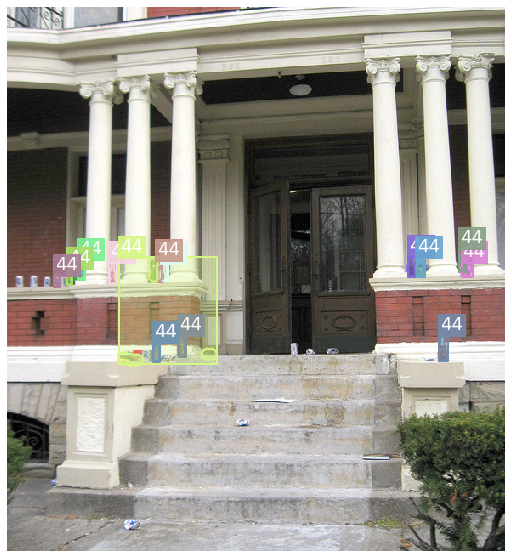

In [ ]:
record = rtrain[3]
show_record(record)

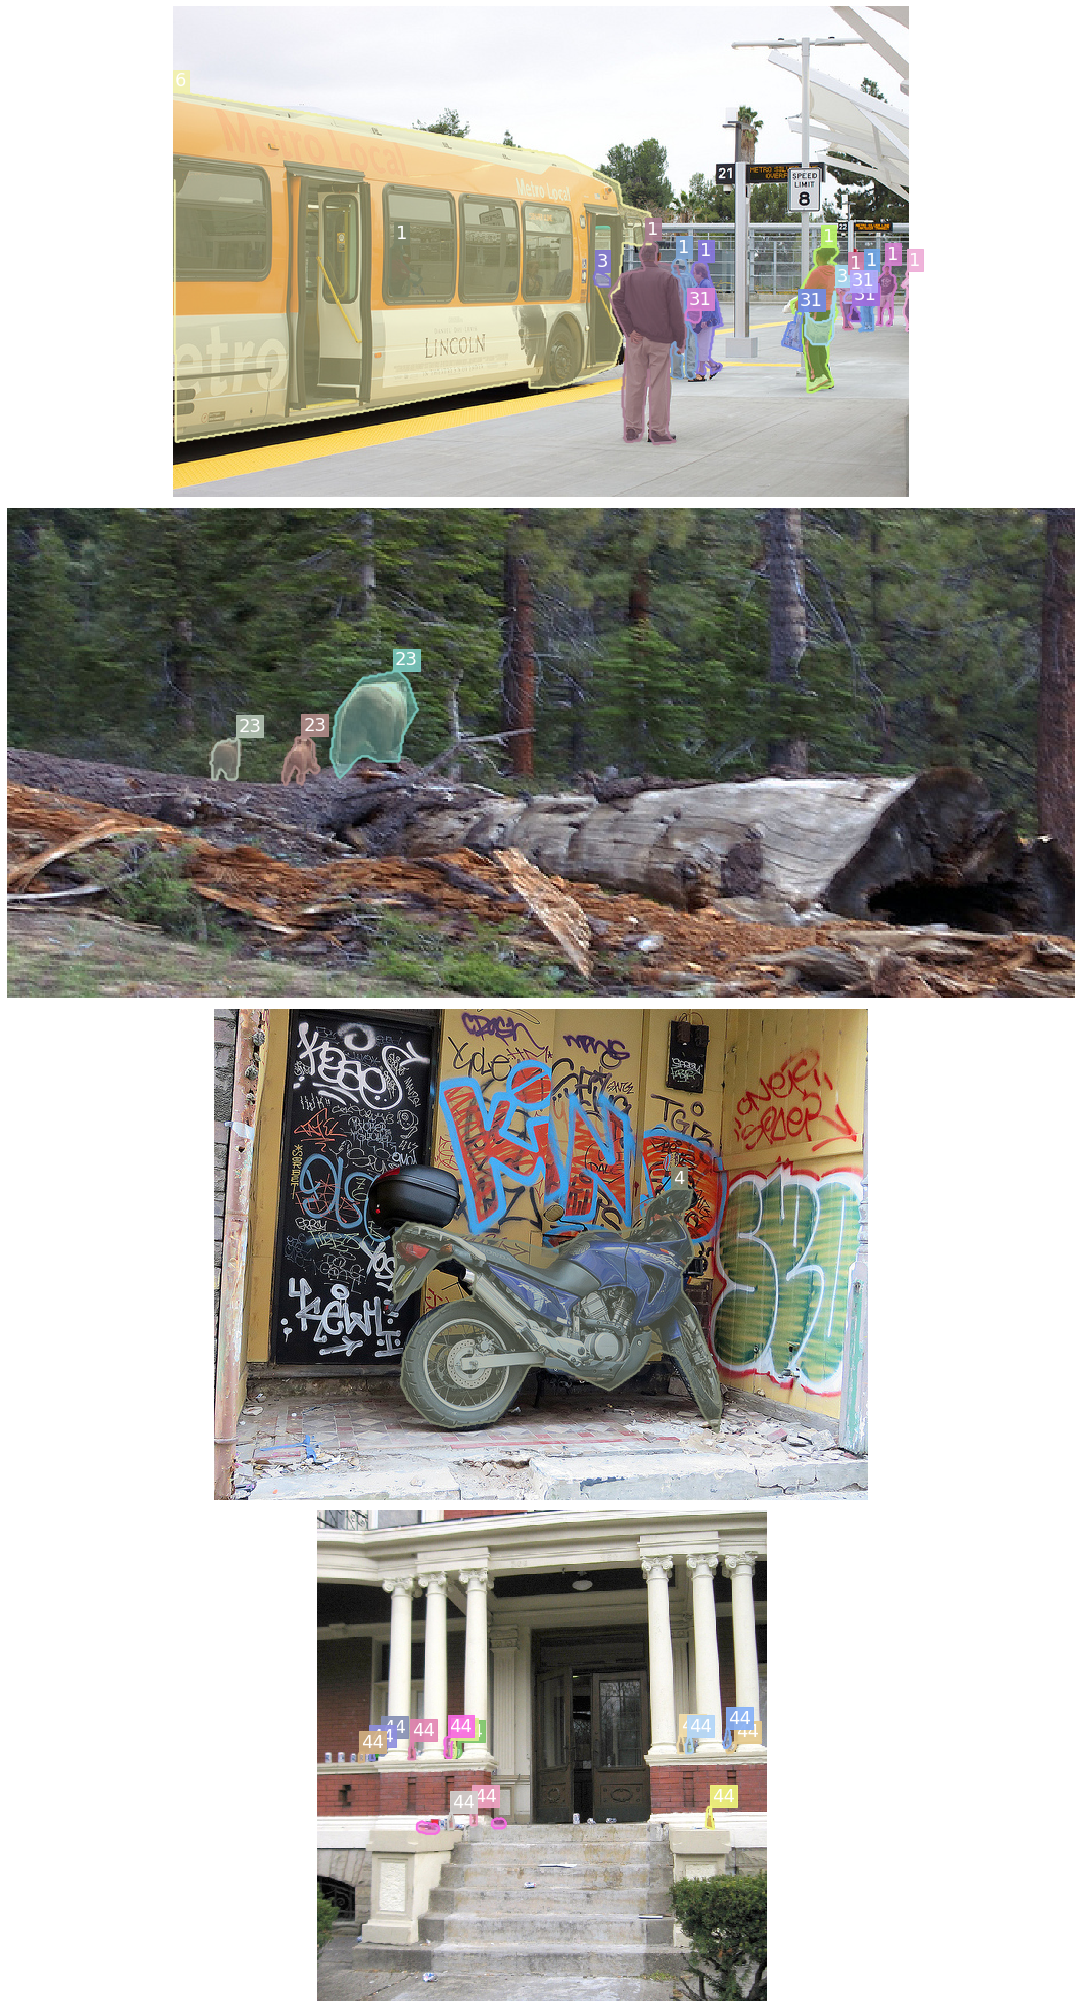

In [ ]:
grid(partial(show_record, bbox=False), rtrain)

## Export -

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 02_data.core.ipynb.
Converted 04_data.annotations.ipynb.
Converted 06_transforms.ipynb.
Converted 07_data.load.ipynb.
Converted 08_models.ipynb.
Converted 11_metrics.core.ipynb.
Converted Untitled.ipynb.
Converted Untitled1.ipynb.
Converted index.ipynb.
